In [124]:
import os

import torch
from torch.utils.data import DataLoader
from torchvision import datasets
import torch.nn as nn
import torch.nn.functional as F
from torchmetrics.functional import accuracy
import torchvision

import lightning as L
from lightning.pytorch.callbacks.early_stopping import EarlyStopping
from lightning.pytorch.loggers import TensorBoardLogger

from mpl_toolkits.axes_grid1 import ImageGrid
import matplotlib.pyplot as plt
import numpy as np

In [125]:
BATCH_SIZE = 256 if torch.cuda.is_available() else 64
NUM_WORKERS = int(os.cpu_count() / 2)

In [126]:
transformation = torchvision.transforms.Compose(
    [
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize((0.1307,), (0.3081,))
    ]
)

# Download the dataset and create the dataloaders
mnist_data = datasets.MNIST("./", train=True, download=True, transform=transformation)

mnist_train, mnist_val = torch.utils.data.random_split(mnist_data, [55000, 5000])

train_loader = DataLoader(mnist_train, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, persistent_workers=True)
val_loader = DataLoader(mnist_val, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

mnist_test = datasets.MNIST("./", train=False, download=True, transform=transformation)
test_loader = DataLoader(mnist_test, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, persistent_workers=True)

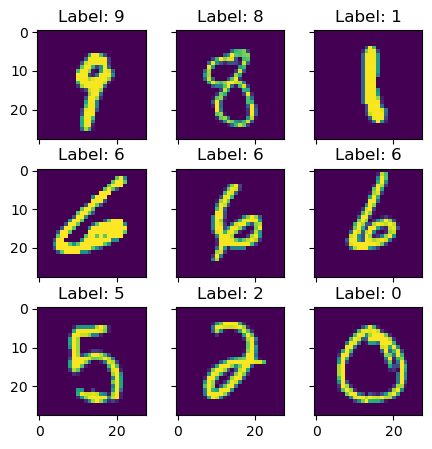

In [152]:
# TODO
for images,lables in train_loader: 
    images = images[:9]
    fig = plt.figure(1, (5., 5.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(3, 3),  # creates 2x2 grid of axes
                    axes_pad=0.3,  # pad between axes in inch.
                    )

    for i in range(len(images)):
        image = images[i].reshape(28,28)
        grid[i].imshow(image)
        grid[i].set_title('Label: {0}'.format(lables[i]))

    plt.show()
    break

In [128]:
class MnistCNN(nn.Module):
    def __init__(self):
        super(MnistCNN, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(1, 3, 3),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(3, 6, 3),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(726, 120),
            nn.ReLU(),
            nn.Linear(120, 10)
        )

    def forward(self, x):
        return self.model(x)

In [129]:
class LightningMNISTClassifier(L.LightningModule):

  def __init__(self, num_classes, lr):
    super(LightningMNISTClassifier, self).__init__()
    
    self.save_hyperparameters(ignore=['model'])
    self.model = MnistCNN()
    self.num_classes = num_classes

  def forward(self, x):
      return self.model(x)

  def training_step(self, batch, batch_idx):
      # training_step defines the train loop.
      images, labels = batch
        
      # Forward pass
      outputs = self.model(images)
      loss = F.cross_entropy(outputs, labels)
        
      # Logging to TensorBoard (if installed) by default
      self.log("train_loss", loss)
        
      return loss
    
  def evaluate(self, batch, stage=None):
      images, labels = batch
        
      # Forward pass
      outputs = self.model(images)
      loss = F.cross_entropy(outputs, labels)
        
      acc = accuracy(outputs, labels, task="multiclass", num_classes=self.num_classes)

      if stage:
          self.log(f"{stage}_loss", loss, prog_bar=True)
          self.log(f"{stage}_acc", acc, prog_bar=True)
    
  def validation_step(self, batch, batch_idx):
      self.evaluate(batch, "val")
    
  def test_step(self, batch, batch_idx):
      self.evaluate(batch, "test")

  def configure_optimizers(self):
      return torch.optim.Adam(self.parameters(), lr=self.hparams.lr)

In [130]:
convNet = LightningMNISTClassifier(lr=0.001, num_classes=10)
#logger = CSVLogger("logs", name="my_logs")
logger = TensorBoardLogger("tb_logs", name="mnist_model")
trainer = L.Trainer(max_epochs=20, 
                    callbacks=[EarlyStopping(monitor="val_loss", mode="min")],
                    accelerator="auto",
                    #devices=1 if torch.cuda.is_available() else None,
                    logger=logger,
                    fast_dev_run=False)

# train the model
trainer.fit(convNet, train_dataloaders=train_loader, val_dataloaders=val_loader)

# test the model
trainer.test(convNet, dataloaders=test_loader)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs

  | Name  | Type     | Params
-----------------------------------
0 | model | MnistCNN | 88.6 K
-----------------------------------
88.6 K    Trainable params
0         Non-trainable params
88.6 K    Total params
0.355     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc             0.98580002784729
        test_loss          0.051122795790433884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'test_loss': 0.051122795790433884, 'test_acc': 0.98580002784729}]

In [131]:
trainer.save_checkpoint("best_mnist_cnn_model.ckpt")

In [132]:
def plot_predictions(model, image_list, output_probs=False, adversarial=False):
    '''
    Evaluate images against trained model and plot images.
    If adversarial == True, replace middle image title appropriately
    Return probability list if output_probs == True
    '''
    #prob = y.eval(feed_dict={x: image_list, keep_prob: 1.0})
    prob = model(image_list)
    probabilities = torch.nn.functional.softmax(prob, dim=1)
    
    pred_list = np.zeros(len(image_list)).astype(int)
    pct_list = np.zeros(len(image_list)).astype(int)
    
    # Setup image grid
    import math
    cols = 3
    rows = math.ceil(image_list.shape[0]/cols)
    fig = plt.figure(1, (12., 12.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                     nrows_ncols=(rows, cols),  # creates grid of axes
                     axes_pad=0.5,  # pad between axes in inch.
                     )
    
    # Get probs, images and populate grid
    for i in range(len(prob)):
        pred_list[i] = np.argmax(probabilities[i].detach().numpy()) # for mnist index == classification
        
        pct_list[i] = probabilities[i][pred_list[i]] * 100

        image = image_list[i].reshape(28,28)
        grid[i].imshow(image.detach().numpy())
        
        grid[i].set_title('Label: {0} \nCertainty: {1}%' \
                          .format(pred_list[i], 
                                  pct_list[i]))
        
        # Only use when plotting original, partial deriv and adversarial images
        if (adversarial) & (i % 3 == 1): 
            grid[i].set_title("Adversarial \nPartial Derivatives")
        
    plt.show()
    
    return prob if output_probs else None

In [133]:
indices = mnist_test.targets == 2 # if you want to keep images with the label 2
images= mnist_test.data[indices].type(torch.float32)
images = images[:10]
images = images.unsqueeze(1)
print(images.shape)

torch.Size([10, 1, 28, 28])


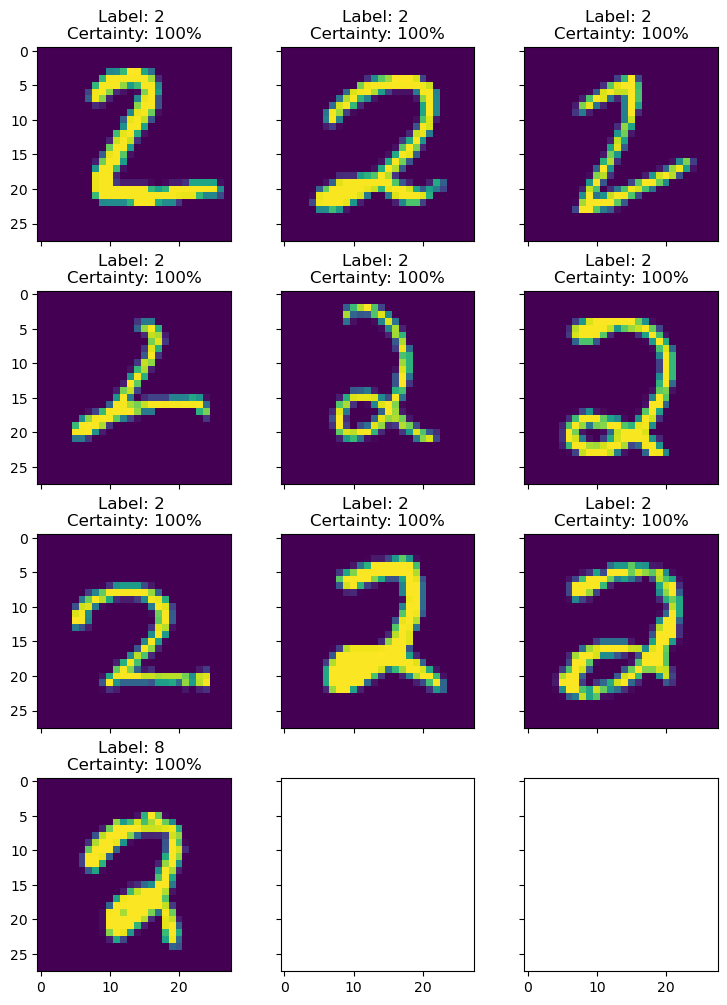

In [134]:
# load model
cnn_mnist = LightningMNISTClassifier.load_from_checkpoint("best_mnist_cnn_model.ckpt")

# disable randomness, dropout, etc...
cnn_mnist.eval()
    
with torch.no_grad():
    plot_predictions(cnn_mnist, images)

In [135]:
print("CUDA Available: ",torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

CUDA Available:  False


In [136]:
# FGSM attack code
def fgsm_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

In [137]:
# restores the tensors to their original scale
def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [145]:
# Mostly inspired by:
# https://codewords.recurse.com/issues/five/why-do-neural-networks-think-a-panda-is-a-vulture
def create_plot_adversarial_images(model, x_image, y_label, lr=0.1, n_steps=1, output_probs=False):
    
    original_image = x_image
    probs_per_step = []
    
    # Forward pass the data through the model
    output = model(x_image)
    #init_pred = output.max(1, keepdim=True)[1] # get the index of the max log-probability
    
    # Calculate the loss
    loss = F.nll_loss(output, y_label)
    
    # Zero all existing gradients
    model.zero_grad()

    # Calculate gradients of model in backward pass
    loss.backward()

    # Collect ``datagrad``
    data_grad = x_image.grad.data

    # Restore the data to its original scale
    data_denorm = denorm(x_image)

    # Call FGSM Attack
    perturbed_data = fgsm_attack(data_denorm, lr, data_grad)
    
    # Reapply normalization
    perturbed_data_normalized = torchvision.transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
    
    img_adv_list = original_image.detach().numpy()
    img_adv_list = np.append(img_adv_list, data_grad.detach().numpy(), axis=0)
    img_adv_list = np.append(img_adv_list, perturbed_data_normalized.detach().numpy(), axis=0)
    img_adv_list = torch.tensor(img_adv_list)

    # Print/plot images and return probabilities
    probs = plot_predictions(model, img_adv_list, output_probs=output_probs, adversarial=True)
    probs_per_step.append(probs) if output_probs else None
    
    

In [164]:
# Pick a random 2 image from first 1000 images 
# Create adversarial image and with target label 6
index_of_2s = mnist_test.targets == 2
rand_index = np.random.randint(0, index_of_2s.sum())
image_norm = mnist_test.data[index_of_2s][rand_index].type(torch.float32).unsqueeze(0).unsqueeze(1)
image_norm.requires_grad = True
label_adv = torch.tensor([2], dtype=torch.long)

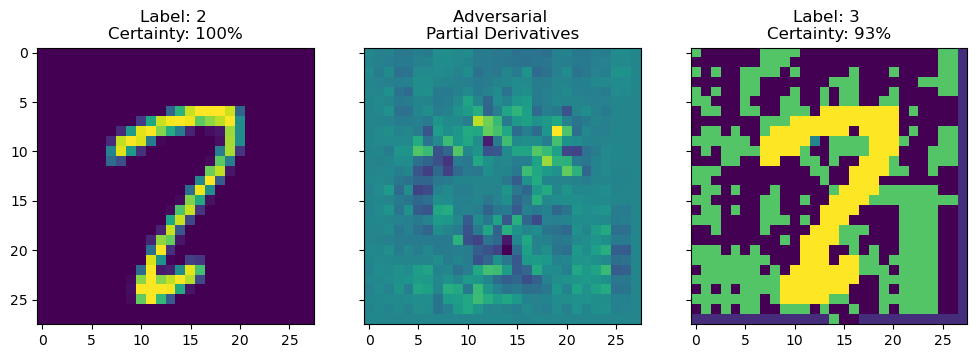

In [169]:
# Plot adversarial images
# Over each step, model certainty changes from 2 to 6
create_plot_adversarial_images(cnn_mnist, image_norm, label_adv, lr=0.6, n_steps=5)

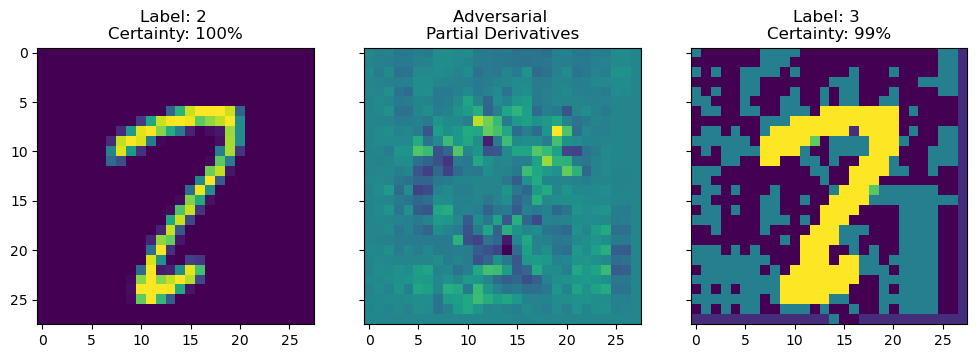

In [166]:
create_plot_adversarial_images(cnn_mnist, image_norm, label_adv, lr=0.3, n_steps=5)

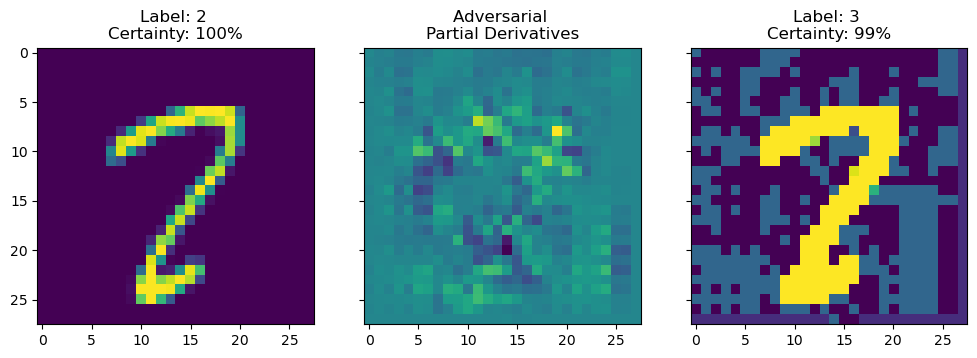

In [167]:
create_plot_adversarial_images(cnn_mnist, image_norm, label_adv, lr=0.2, n_steps=5)

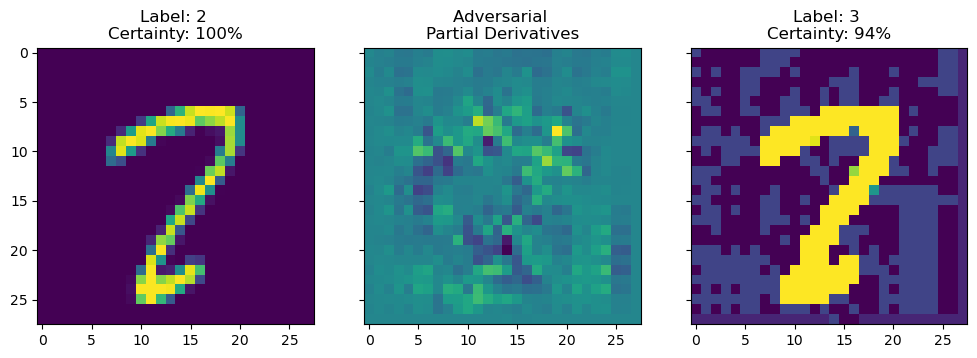

In [168]:
create_plot_adversarial_images(cnn_mnist, image_norm, label_adv, lr=0.1, n_steps=5)